In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, re

from astropy.table import Table, join, Column

from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
from thejoker import compute_likelihoods, likelihood

import astropy.units as u
import corner

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
ls ../results/*hdf5

../results/results_video.hdf5      ../results/results_video_14.hdf5
../results/results_video0.hdf5     ../results/results_video_15.hdf5
../results/results_video1.hdf5     ../results/results_video_16.hdf5
../results/results_video2.hdf5     ../results/results_video_2.hdf5
../results/results_video_0.hdf5    ../results/results_video_5.hdf5
../results/results_video_1.hdf5    ../results/results_video_6.hdf5
../results/results_video_10.hdf5   ../results/results_video_7.hdf5
../results/results_video_11.hdf5   ../results/results_video_feb.hdf5
../results/results_video_12.hdf5   ../results/results_video_old.hdf5


In [3]:
ls ../rv*

../rvs.csv               ../rvs_11.csv            ../rvs_5.csv
../rvs0.csv              ../rvs_12.csv            ../rvs_6.csv
../rvs1.csv              ../rvs_14.csv            ../rvs_7.csv
../rvs_0.csv             ../rvs_15.csv            ../rvs_feb.csv
../rvs_1.csv             ../rvs_16.csv            ../rvs_just_the_new.csv
../rvs_10.csv            ../rvs_2.csv             ../rvs_old.csv


In [4]:
fname = '../data/rvs_feb.csv'
fname_old = '../rvs_old.csv'
fname_new = '../rvs_feb.csv'
fname_new = '../rvs0.csv'
fname = '../rvs.csv'
fname = '../data/rvs_fixed.csv'
fname = '../rvs_11.csv'
fname = '../rvs.csv'
data = Table.read(fname)
data_old = Table.read(fname_old)
data_new = Table.read(fname_new)


In [5]:
t = data['JD']
rv = data['RV_wobble'] * u.m/u.s
err =  data['RV_err_wobble'] * u.m/u.s
# err[~np.isfinite(err)] = 300 * u.m/u.s
# err = 30*np.ones_like(data['RV_wobble'])* u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)

t_old = data_old['JD']
rv_old = data_old['RV_wobble'] * u.m/u.s
err_old =  data_old['RV_err_wobble'] * u.m/u.s
data_old = RVData(t=t_old, rv=rv_old, stddev=err_old)


t_new = data_new['JD']
rv_new = data_new['RV_wobble'] * u.m/u.s
err_new =  data_new['RV_err_wobble'] * u.m/u.s
data_new = RVData(t=t_new, rv=rv_new, stddev=err_new)


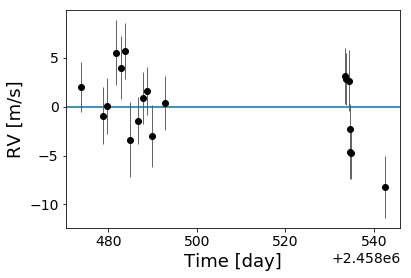

In [6]:
ax = data.plot() # doctest: +SKIP
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
plt.axhline(0)

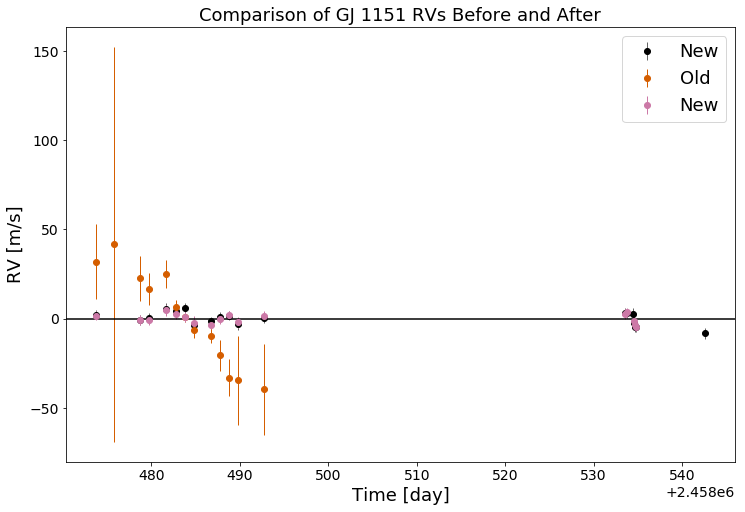

In [7]:
f = plt.figure(figsize=(12.0,8.0))

ax = data.plot(label='New') # doctest: +SKIP
data_old.plot(color=colours[2],ecolor=colours[2],label='Old')
data_new.plot(color=colours[3],ecolor=colours[3],label='New')
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
plt.axhline(0,color='k')
plt.legend(fontsize=18)
plt.title('Comparison of GJ 1151 RVs Before and After',fontsize=18)
plt.savefig('before_and_after.png',bbox_inches='tight')

In [8]:
data.t.max()

<Time object: scale='tcb' format='mjd' value=2458542.55801924>

Text(0.5, 0.95, 'GJ 1151 Reductions')

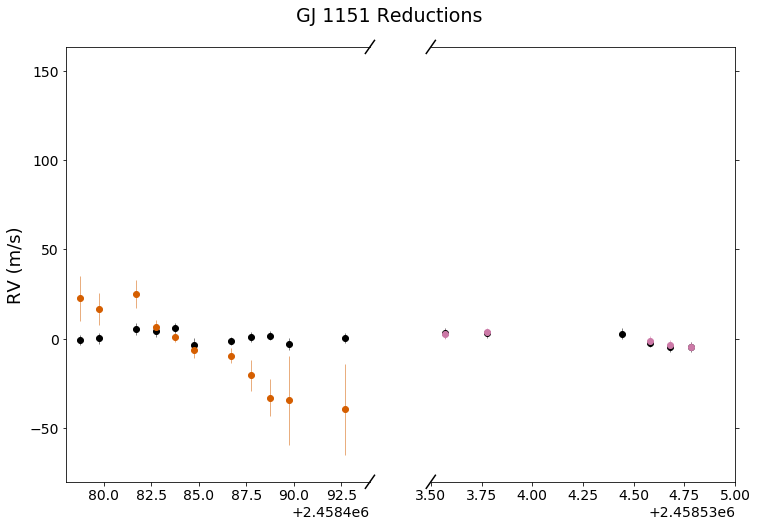

In [9]:
f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w',figsize=(12.0,8.0))

# plot the same data on both axes
ax.errorbar(data.t.value,data.rv.value,yerr=data.stddev.value,color='k',label='All',fmt='.',markersize=12,linewidth=0.5)
ax2.errorbar(data.t.value,data.rv.value,yerr=data.stddev.value,color='k',label='All',fmt='.',markersize=12,linewidth=0.5)

ax.errorbar(data_old.t.value,data_old.rv.value,yerr=data_old.stddev.value,
            color=colours[2],ecolor=colours[2],label='Old',fmt='.',markersize=12,linewidth=0.5)

ax2.errorbar(data_new.t.value,data_new.rv.value,yerr=data_new.stddev.value,
             color=colours[3],ecolor=colours[3],label='New',fmt='.',markersize=12,linewidth=0.5)

ax.set_xlim(2458478,2458478+16)
ax2.set_xlim(2458534-0.5,2458535)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright=False)
ax2.yaxis.tick_right()
ax.set_ylabel('RV (m/s)')

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

f.suptitle('GJ 1151 Reductions',y=0.95,fontsize=19)
# plt.savefig('comparison.png',bbox_inches='tight')

In [10]:
params = JokerParams(P_min=0.5*u.day, P_max=20*u.day,jitter=(1., 2.), jitter_unit=u.m/u.s)

In [11]:
params_trend = JokerParams(P_min=0.5*u.day, P_max=20*u.day,poly_trend=2,jitter=(1., 2.), jitter_unit=u.m/u.s)

In [57]:
# do trend
joker = TheJoker(params_trend)

In [58]:
2**14

16384

In [59]:
%%time
samples_trend = joker.rejection_sample(data, n_prior_samples=2**20)

INFO:thejoker:1252 good samples after rejection sampling


INFO: 1252 good samples after rejection sampling [thejoker.sampler.sampler]
CPU times: user 7.52 s, sys: 181 ms, total: 7.7 s
Wall time: 7.31 s


CPU times: user 6.71 s, sys: 114 ms, total: 6.82 s
Wall time: 6.3 s


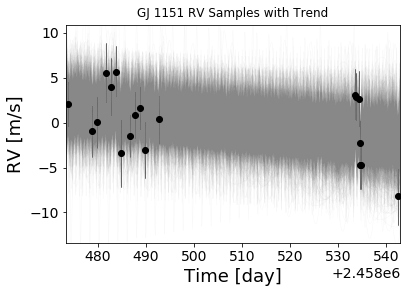

In [83]:
%%time
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024)

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_trend[:1024], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples with Trend',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.max()+0.5)
ax.set_ylim((rv-err).min().value-2.,(rv+err).max().value+2.)

plt.savefig('gj1151b_samples_trend.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples_trend.pdf',bbox_inches='tight')


In [61]:
samples_trend['jitter'].mean()

<Quantity 0.87384837 m / s>

In [62]:
samples_trend.keys()

odict_keys(['P', 'M0', 'e', 'omega', 'jitter', 'K', 'v0', 'v1'])

In [63]:
test = samples_trend.copy()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.01, 'Constraints on GJ 1151 b K')

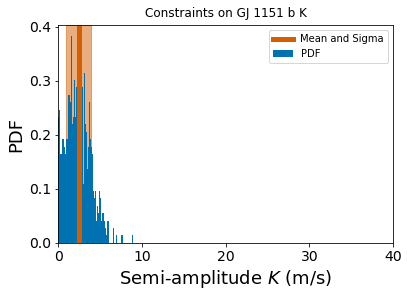

In [64]:
plt.xlim(0,40)
plt.axvline(test['K'].value.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(test['K'].value.mean()-test['K'].value.std(),test['K'].value.mean()+test['K'].value.std(),color=colours[2],alpha=0.5)
h = plt.hist(test['K'].value,bins=200,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'Semi-amplitude $K$ (m/s)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b K',y=1.01)
# plt.savefig('gj1151b_posterior.png',bbox_inches='tight')
# plt.savefig('gj1151b_posterior.pdf',bbox_inches='tight')

### Now let's calculate the planet's mass

In [75]:
Ps = samples_trend['P'].to(u.d).value

eccs = samples_trend['e'].value

Ks = samples_trend['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 


In [76]:
print(Mstar-dMstar/2.,Mstar+dMstar/2.)

0.1545 0.17950000000000002


In [77]:
Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [78]:
print('Msini: %.2f +- %.2f' % (np.mean(Msini), np.std(Msini)),'M_Earth')

Msini: 1.66 +- 1.16 M_Earth


In [79]:
print(np.percentile(Msini,99))

4.957160297150996


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


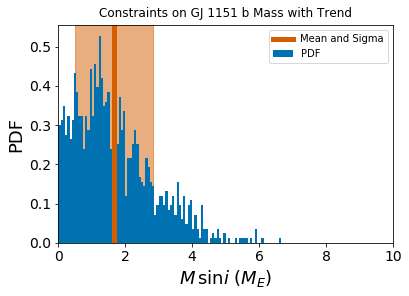

In [80]:
plt.xlim(0,10.)
plt.axvline(Msini.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(Msini.mean()-Msini.std(),Msini.mean()+Msini.std(),color=colours[2],alpha=0.5)
h = plt.hist(Msini,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'$M\, \sin{i}$ ($M_E$)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b Mass with Trend',y=1.01)
plt.savefig('gj1151b_mass_trend.png',bbox_inches='tight')
plt.savefig('gj1151b_mass_trend.pdf',bbox_inches='tight')

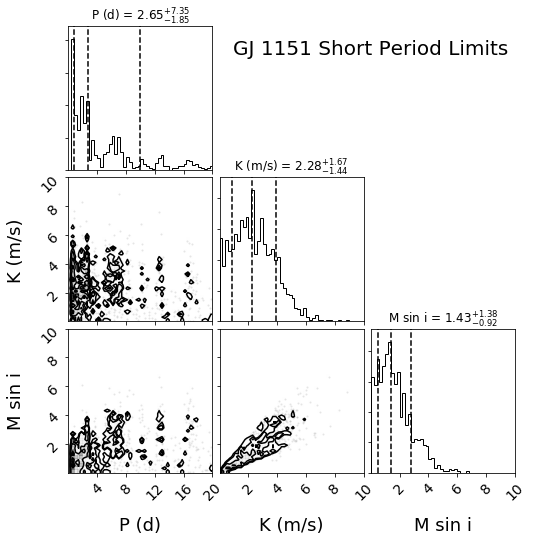

In [82]:
dummy = np.array([samples_trend['P'].value,samples_trend['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)','M sin i'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,20),(0,10),(0,10)));
figure.gca().annotate("GJ 1151 Short Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

plt.savefig('cornerplot_km_trend.png',bbox_inches='tight')
# plt.savefig('cornerplot_km_trend.pdf',bbox_inches='tight')


In [84]:
# do without trend
# params = JokerParams(P_min=0.5*u.day, P_max=20*u.day)
# params = JokerParams(P_min=0.95*u.day, P_max=1.05*u.day)

joker = TheJoker(params)
samples_long = joker.rejection_sample(data, n_prior_samples=2**20)

INFO:thejoker:318 good samples after rejection sampling


INFO: 318 good samples after rejection sampling [thejoker.sampler.sampler]


CPU times: user 683 ms, sys: 8.42 ms, total: 691 ms
Wall time: 689 ms


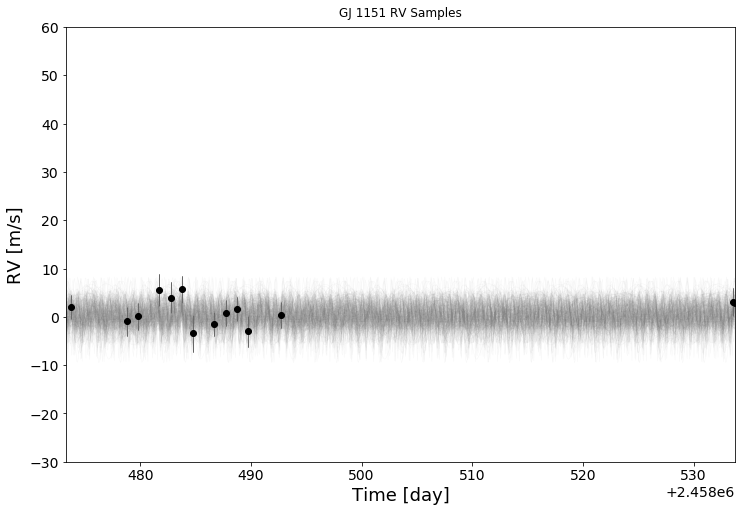

In [92]:
%%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[:2048], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.min()+60.)
# ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
plt.ylim(-30,60)
# plt.axvline(t.min()+55)
# plt.text(t.min()+56,100,'today')
# plt.savefig('gj1151b_samples_new.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


CPU times: user 664 ms, sys: 6.72 ms, total: 670 ms
Wall time: 669 ms


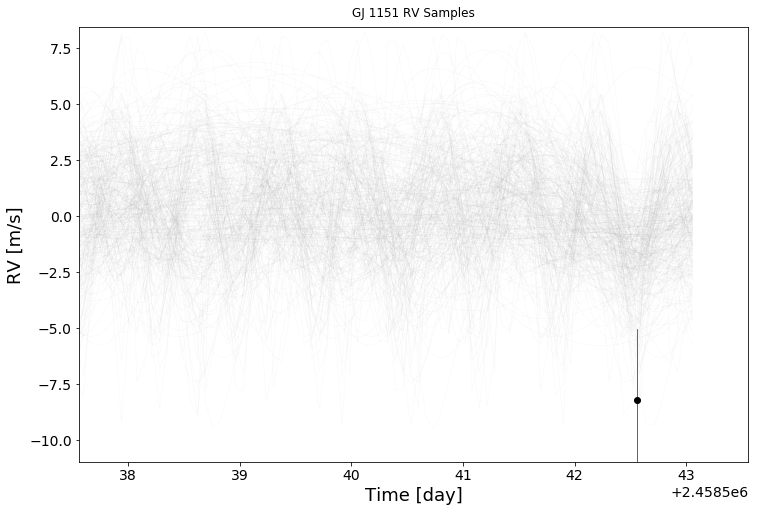

In [86]:
%%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[:1024], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
# ax.set_xlim(t.min()-0.5,t.max()+0.5)
ax.set_xlim(t.max()-5,t.max()+1)
# ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
# plt.savefig('gj1151b_samples.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


In [87]:
t.max()

2458542.55801924

In [88]:
Ps = samples_long['P'].to(u.d).value

eccs = samples_long['e'].value

Ks = samples_long['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 

Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

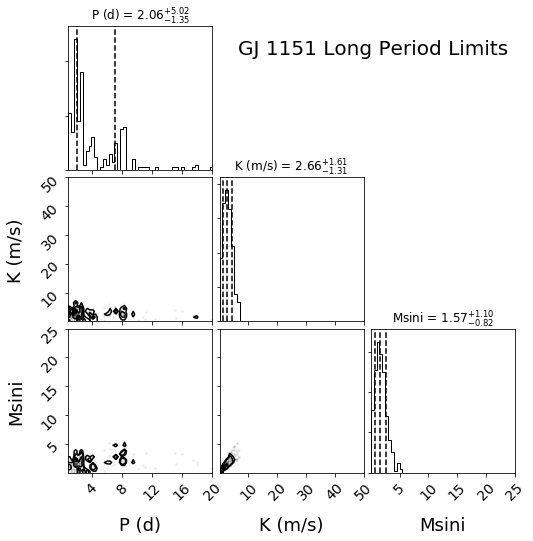

In [89]:
dummy = np.array([samples_long['P'].value,samples_long['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0.9,20),(0,50),(0,25)));
figure.gca().annotate("GJ 1151 Long Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

plt.savefig('cornerplot_km_long.png',bbox_inches='tight')
# plt.savefig('cornerplot_km_long.pdf',bbox_inches='tight')


In [90]:
short = samples_long['P'].value<5
# h = plt.hist(samples_long['P'][short])

Text(-25, -40, 'GJ 1151 Short Period Alias')

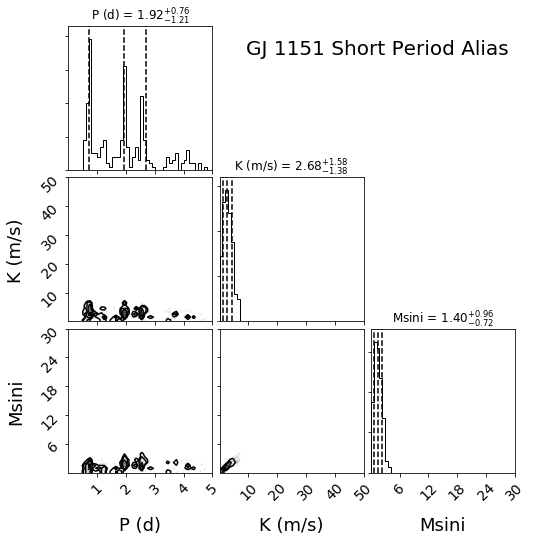

In [91]:
dummy = np.array([samples_long['P'].value[short],samples_long['K'].value[short],Msini[short]]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,5),(0,50),(0,30)));
figure.gca().annotate("GJ 1151 Short Period Alias",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

# plt.savefig('cornerplot_km_vshort.png',bbox_inches='tight')
# plt.savefig('cornerplot_km_long.pdf',bbox_inches='tight')


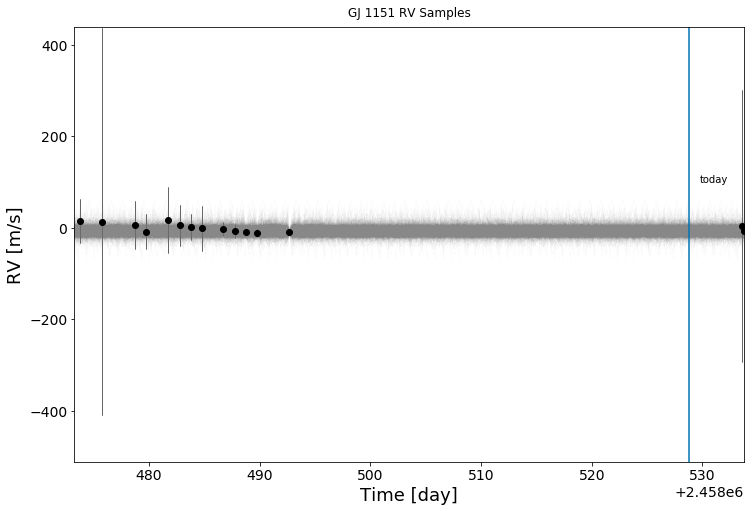

In [47]:
# %%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.min()+60., 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[short], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.min()+60.)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
plt.axvline(t.min()+55)
plt.text(t.min()+56,100,'today')

plt.savefig('gj1151b_samples_short_predict.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


### check time sampling

In [ ]:
print(['%.2f' % s for s in ((data.t-data.t0).value % 1.)*100])

### Try with TRES data as well

In [ ]:
tres_t = [2457764.977731,2458110.061319,2458471.011988,2458475.895541] 
tres_rv = [0.0839,  0.1237,0.0630,0.0195] 
tres_rv_err = [0.0643,0.0502,0.0589,0.0472]

In [ ]:
fname = '../data/rvs_new.csv'
data = Table.read(fname)

t = np.concatenate([np.array(tres_t),data['JD'].data])*u.day
rv = np.concatenate([np.array(tres_rv)*1000.,data['RV_wobble'].data])* u.m/u.s
err = np.concatenate([np.array(tres_rv_err)*1000.,data['RV_err_wobble'].data])* u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)


In [ ]:
joker = TheJoker(params)
samples = joker.rejection_sample(data, n_prior_samples=16384*8)

In [ ]:
# %%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.value.min()-0.5, t.value.max()+0.5, 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
data_old.plot(color=colours[2])
plot_rv_curves(samples[:2048], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.value.min()-0.5, t.value.max()+0.5)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
# plt.axvline(t.min()+55)
# plt.text(t.min()+56,100,'today')
plt.savefig('gj1151b_samples_tres.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


In [ ]:
Ps = samples['P'].to(u.d).value

eccs = samples['e'].value

Ks = samples['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 

Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [ ]:
dummy = np.array([samples['P'].value,samples['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,200),(0,300),(0,1200)));
figure.gca().annotate("GJ 1151 Long Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

plt.savefig('cornerplot_km_tres.png',bbox_inches='tight')


In [ ]:
samples_trend